# 1. Training


In [3]:
import os                       
import tensorflow as tf         
import tensorflow.keras as K    
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline
import cv2                      
import datetime

In [4]:
input_size = 256 
batch_size= 16

## 1-1. Perceptual loss

In [5]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = K.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

80134624/80134624 [==============================] - 1s 0us/step


In [6]:
# Perceptual loss function

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None,None,3))
vgg_layer = K.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
for l in vgg_layer.layers: l.trainable=False

def perceptual_loss(y_true,y_pred):
    y_t=vgg_layer(y_true)
    y_p=vgg_layer(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

In [7]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

## 1-2. Data process

In [8]:
def image_proc_net(training_mode=True):
    inputs = K.layers.Input((None, None, 3))

    x = K.layers.MaxPool2D(pool_size=(2,2))(inputs)
    x = K.layers.GaussianNoise(5)(x)
    x = K.layers.UpSampling2D((2,2))(x)

    model = K.models.Model(inputs, x)

    for l in model.layers: l.trainable=False

    return model

image_proc_train = image_proc_net(training_mode=True)
image_proc_test = image_proc_net(training_mode=False)

In [9]:
def image_preprocess(image, training_mode=True):
    image = np.expand_dims(image,axis=0)
    if training_mode:
        return tf.squeeze(image_proc_train(image))
    else:
        return tf.squeeze(image_proc_test(image))

In [10]:
def read_image(img_path):
    img = cv2.imread(img_path)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])

    return img

In [11]:
all_images = []

train_list = []
val_list = []

path = 'data/Website_Screenshots/train/sharp/'

img_files = os.listdir(path)
for img_file in img_files:
    path_file = path + img_file
    all_images.append(path_file)

np.random.shuffle(all_images) 

train_len = int(len(all_images)*0.85)
train_list = all_images[:train_len]
val_list = all_images[train_len:]


test_list = []

path = 'data/Website_Screenshots/valid/sharp/'

img_files = os.listdir(path)
for img_file in img_files:
    path_file = path + img_file
    test_list.append(path_file)

np.random.shuffle(test_list) 

test_list = test_list[:500]

print('images: ')
print('train:', len(train_list), 'val:', len(val_list), 'test:', len(test_list))

images: 
train: 7080 val: 1250 test: 500


In [12]:
def train_generator():
    global batch_size
    while True:
        for start in range(0, len(train_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(train_list))
                    ids_train_batch = train_list[start:end]
                    for i,ids in enumerate(ids_train_batch):
                        img_y = read_image(ids)
                        img_x = image_preprocess(img_y, training_mode=True)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch

def valid_generator():
    global batch_size
    while True:
        for start in range(0, len(val_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(val_list))
                    ids_val_batch = val_list[start:end]
                    for i,ids in enumerate(ids_val_batch):
                        img_y = read_image(ids)
                        img_x = image_preprocess(img_y, training_mode=True)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch


def test_generator():
    global batch_size
    while True:
        for start in range(0, len(test_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(test_list))
                    ids_test_batch = test_list[start:end]
                    for i,ids in enumerate(ids_test_batch):
                        img_y = read_image(ids)
                        img_x = image_preprocess(img_y, training_mode=False)
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ckpt',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## 1-3. Model architecture

In [14]:
def pixel_shuffle(scale):
    if scale > 1:
        return lambda x: tf.nn.depth_to_space(x, scale)
    else:
        return lambda x:x

In [15]:
def add_down_block(x_inp, filters, kernel_size=(3, 3), padding="same", strides=1,r=False):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    if r:
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x

def add_up_block(x_inp,skip,filters, kernel_size=(3, 3), padding="same", strides=1,upscale_factor=2):
    x = pixel_shuffle(scale=upscale_factor)(x_inp)
    x = K.layers.Concatenate()([x, skip])
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Activation('relu')(x)
    return x

def add_bottleneck(x_inp,filters, kernel_size=(3, 3), padding="same", strides=1):
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.Activation('relu')(x)
    return x

In [16]:
def RUNet():
    """
      Implementing with Keras the Robust UNet Architecture as proposed by
      Xiaodan Hu, Mohamed A. Naiel, Alexander Wong, Mark Lamm, Paul Fieguth
      in "RUNet: A Robust UNet Architecture for Image Super-Resolution"
    """
    inputs = K.layers.Input((input_size,input_size, 3))


    down_1 = K.layers.Conv2D(64,(7,7), padding="same", strides=1)(inputs)
    down_1 = K.layers.BatchNormalization()(down_1)
    down_1 = K.layers.Activation('relu')(down_1)

    down_2 = K.layers.MaxPool2D(pool_size=(2,2))(down_1)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,64)
    down_2 = add_down_block(down_2,128,r=True)

    down_3 = K.layers.MaxPool2D(pool_size=(2, 2),strides=2)(down_2)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,128)
    down_3 = add_down_block(down_3,256,r=True)

    down_4 = K.layers.MaxPool2D(pool_size=(2, 2))(down_3)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,256)
    down_4 = add_down_block(down_4,512,r=True)

    down_5 = K.layers.MaxPool2D(pool_size=(2, 2))(down_4)
    down_5 = add_down_block(down_5,512)
    down_5 = add_down_block(down_5,512)
    down_5 = K.layers.BatchNormalization()(down_5)
    down_5 = K.layers.Activation('relu')(down_5)


    bn_1 = add_bottleneck(down_5, 1024)
    bn_2 = add_bottleneck(bn_1, 512)

    up_1 = add_up_block(bn_2,down_5, 512,upscale_factor=1)
    up_2 = add_up_block(up_1,down_4, 384,upscale_factor=2)
    up_3 = add_up_block(up_2,down_3, 256,upscale_factor=2)
    up_4 = add_up_block(up_3,down_2, 96,upscale_factor=2)

    up_5 = pixel_shuffle(scale=2)(up_4)
    up_5 = K.layers.Concatenate()([up_5,down_1])
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)
    up_5 = K.layers.Conv2D(99,(3,3), padding="same", strides=1)(up_5)
    up_5 = K.layers.Activation('relu')(up_5)

    outputs = K.layers.Conv2D(3,(1,1), padding="same")(up_5)
    model = K.models.Model(inputs, outputs)
    return model

model = RUNet()
global model
# model.summary()

## 1-4. training

In [ ]:
opt=K.optimizers.Adam(learning_rate=0.001) # Adam optimizer
model.compile(optimizer=opt,loss=perceptual_loss,metrics=[psnr,ssim,K.losses.mean_squared_error])
history = model.fit_generator(generator=train_generator(),
                              steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                              epochs=15,
                              verbose=1,
                              validation_data=valid_generator(),
                              shuffle=True,
                              validation_steps=np.ceil(float(len(val_list)) / float(batch_size)),
                              callbacks=[model_checkpoint_callback],
                              )

<ipython-input-17-529bb5e32dd5>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator(),


Epoch 1/15
443/443 [==============================] - ETA: 0s - loss: 1.3641 - psnr: 26.2648 - ssim: 0.4604 - mean_squared_error: 0.0073

443/443 [==============================] - 3228s 7s/step - loss: 1.3641 - psnr: 26.2648 - ssim: 0.4604 - mean_squared_error: 0.0073 - val_loss: 1.4736 - val_psnr: 23.9970 - val_ssim: 0.7744 - val_mean_squared_error: 0.0128
Epoch 2/15
443/443 [==============================] - ETA: 0s - loss: 0.7893 - psnr: 28.1089 - ssim: 0.6823 - mean_squared_error: 0.0040

443/443 [==============================] - 592s 1s/step - loss: 0.7893 - psnr: 28.1089 - ssim: 0.6823 - mean_squared_error: 0.0040 - val_loss: 0.7602 - val_psnr: 28.4156 - val_ssim: 0.5576 - val_mean_squared_error: 0.0033
Epoch 3/15
443/443 [==============================] - ETA: 0s - loss: 0.7821 - psnr: 28.2616 - ssim: 0.7575 - mean_squared_error: 0.0041

443/443 [==============================] - 599s 1s/step - loss: 0.7821 - psnr: 28.2616 - ssim: 0.7575 - mean_squared_error: 0.0041 - val_loss: 0.7910 - val_psnr: 27.8086 - val_ssim: 0.9090 - val_mean_squared_error: 0.0051
Epoch 4/15
443/443 [==============================] - ETA: 0s - loss: 0.7348 - psnr: 28.6845 - ssim: 0.7974 - mean_squared_error: 0.0037

443/443 [==============================] - 597s 1s/step - loss: 0.7348 - psnr: 28.6845 - ssim: 0.7974 - mean_squared_error: 0.0037 - val_loss: 0.7389 - val_psnr: 30.2143 - val_ssim: 0.8945 - val_mean_squared_error: 0.0024
Epoch 5/15
443/443 [==============================] - ETA: 0s - loss: 0.6876 - psnr: 28.8588 - ssim: 0.8045 - mean_squared_error: 0.0036

443/443 [==============================] - 600s 1s/step - loss: 0.6876 - psnr: 28.8588 - ssim: 0.8045 - mean_squared_error: 0.0036 - val_loss: 0.6846 - val_psnr: 29.8294 - val_ssim: 0.9315 - val_mean_squared_error: 0.0027
Epoch 6/15
443/443 [==============================] - ETA: 0s - loss: 0.6922 - psnr: 28.7795 - ssim: 0.7934 - mean_squared_error: 0.0037

443/443 [==============================] - 599s 1s/step - loss: 0.6922 - psnr: 28.7795 - ssim: 0.7934 - mean_squared_error: 0.0037 - val_loss: 0.7033 - val_psnr: 30.0279 - val_ssim: 0.9176 - val_mean_squared_error: 0.0024
Epoch 7/15
443/443 [==============================] - ETA: 0s - loss: 0.6658 - psnr: 28.7792 - ssim: 0.7636 - mean_squared_error: 0.0036

443/443 [==============================] - 598s 1s/step - loss: 0.6658 - psnr: 28.7792 - ssim: 0.7636 - mean_squared_error: 0.0036 - val_loss: 0.6355 - val_psnr: 30.3249 - val_ssim: 0.9410 - val_mean_squared_error: 0.0024
Epoch 8/15
443/443 [==============================] - ETA: 0s - loss: 0.6403 - psnr: 28.8418 - ssim: 0.7425 - mean_squared_error: 0.0036

443/443 [==============================] - 598s 1s/step - loss: 0.6403 - psnr: 28.8418 - ssim: 0.7425 - mean_squared_error: 0.0036 - val_loss: 0.6472 - val_psnr: 29.7312 - val_ssim: 0.8208 - val_mean_squared_error: 0.0027
Epoch 9/15
443/443 [==============================] - ETA: 0s - loss: 0.6202 - psnr: 29.1558 - ssim: 0.7618 - mean_squared_error: 0.0033

443/443 [==============================] - 594s 1s/step - loss: 0.6202 - psnr: 29.1558 - ssim: 0.7618 - mean_squared_error: 0.0033 - val_loss: 0.6569 - val_psnr: 29.0188 - val_ssim: 0.7524 - val_mean_squared_error: 0.0030
Epoch 10/15
443/443 [==============================] - ETA: 0s - loss: 0.6199 - psnr: 29.0558 - ssim: 0.7464 - mean_squared_error: 0.0033

443/443 [==============================] - 596s 1s/step - loss: 0.6199 - psnr: 29.0558 - ssim: 0.7464 - mean_squared_error: 0.0033 - val_loss: 0.6276 - val_psnr: 30.1944 - val_ssim: 0.7904 - val_mean_squared_error: 0.0023
Epoch 11/15
443/443 [==============================] - ETA: 0s - loss: 0.6030 - psnr: 29.1989 - ssim: 0.7467 - mean_squared_error: 0.0032

443/443 [==============================] - 596s 1s/step - loss: 0.6030 - psnr: 29.1989 - ssim: 0.7467 - mean_squared_error: 0.0032 - val_loss: 0.5890 - val_psnr: 30.4192 - val_ssim: 0.7971 - val_mean_squared_error: 0.0021
Epoch 12/15
443/443 [==============================] - ETA: 0s - loss: 0.5858 - psnr: 29.2829 - ssim: 0.7339 - mean_squared_error: 0.0031

443/443 [==============================] - 595s 1s/step - loss: 0.5858 - psnr: 29.2829 - ssim: 0.7339 - mean_squared_error: 0.0031 - val_loss: 0.5942 - val_psnr: 29.9632 - val_ssim: 0.7378 - val_mean_squared_error: 0.0023
Epoch 13/15
443/443 [==============================] - ETA: 0s - loss: 0.5643 - psnr: 29.4037 - ssim: 0.7320 - mean_squared_error: 0.0029

443/443 [==============================] - 597s 1s/step - loss: 0.5643 - psnr: 29.4037 - ssim: 0.7320 - mean_squared_error: 0.0029 - val_loss: 0.5361 - val_psnr: 31.0041 - val_ssim: 0.8823 - val_mean_squared_error: 0.0019
Epoch 14/15
443/443 [==============================] - ETA: 0s - loss: 0.5444 - psnr: 29.5132 - ssim: 0.7458 - mean_squared_error: 0.0029

443/443 [==============================] - 595s 1s/step - loss: 0.5444 - psnr: 29.5132 - ssim: 0.7458 - mean_squared_error: 0.0029 - val_loss: 0.5502 - val_psnr: 30.9161 - val_ssim: 0.9622 - val_mean_squared_error: 0.0021
Epoch 15/15
443/443 [==============================] - ETA: 0s - loss: 0.4938 - psnr: 29.6822 - ssim: 0.7349 - mean_squared_error: 0.0027

443/443 [==============================] - 594s 1s/step - loss: 0.4938 - psnr: 29.6822 - ssim: 0.7349 - mean_squared_error: 0.0027 - val_loss: 0.4592 - val_psnr: 31.5009 - val_ssim: 0.9422 - val_mean_squared_error: 0.0017


## 1-5. Model save

In [ ]:
model.save_weights("ckpt/runet_ckpt_epoch15_%s" % datetime.datetime.now().strftime('%m%d_%H%M%S'))

In [17]:
# load model
runet_exp = RUNet()
load_status = runet_exp.load_weights("ckpt/runet_ckpt_epoch15_0901_041617")

# 2. Experimental evaluation

## 2-1. Metrics: history

In [ ]:
def history_results(history, par1='loss', par2='val_loss', title='loss'):
    """
    Plot the history of the the 2 metrics (par1, par2) during
    the training (epochs)
    """
    plt.plot(history.history[par1])
    plt.plot(history.history[par2])
    plt.title(title)
    plt.ylabel(par1)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

    return

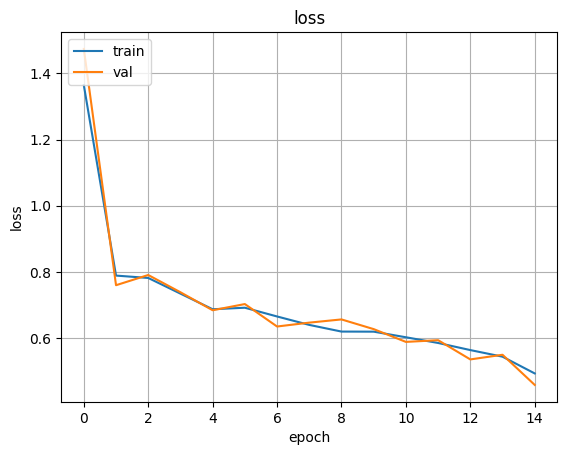

In [ ]:
history_results(history)

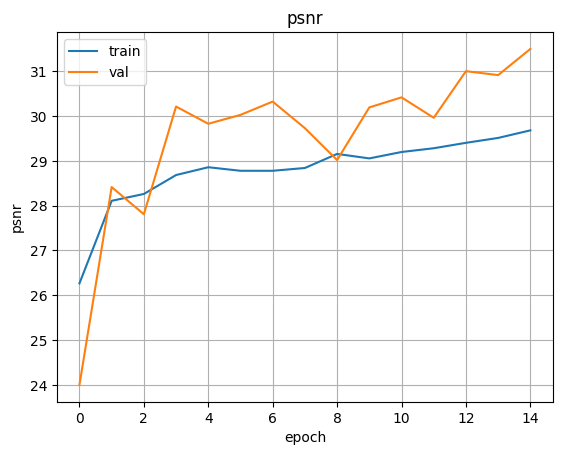

In [ ]:
history_results(history, 'psnr', 'val_psnr', 'psnr')

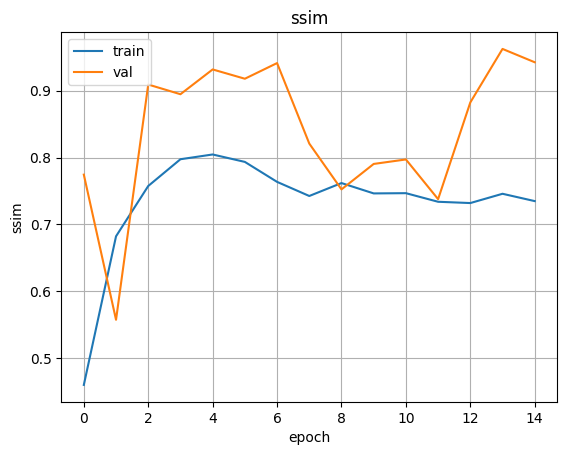

In [ ]:
history_results(history, 'ssim', 'val_ssim', 'ssim')

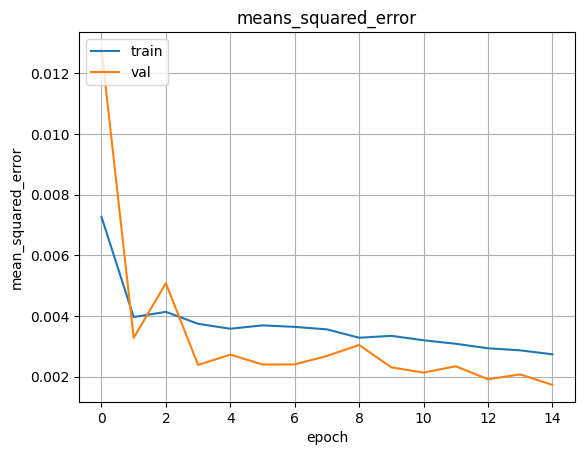

In [ ]:
history_results(history, 'mean_squared_error', 'val_mean_squared_error', 'means_squared_error')

## 2-2. Showing some visual results

In [18]:
def show_pictures(model, img_idx, x_batch, y_batch):
    fig = plt.figure(figsize=(15,18))

    ax1 = fig.add_subplot(1,3,1)
    im = model(np.expand_dims(x_batch[img_idx],axis=0))
    im = np.squeeze(im)
    #ax1.imshow((abs(im) * 255).astype(np.uint8))
    ax1.imshow(abs(im))
    ax1.set_title('Super Resolution (from LR)')

    ax2 = fig.add_subplot(1,3,2)
    #ax2.imshow(x_batch[img_idx] * 255).astype(np.uint8))
    ax2.imshow(x_batch[img_idx])
    ax2.set_title('Low Resolution')

    ax3 = fig.add_subplot(1,3,3)
    #ax3.imshow((y_batch[img_idx] * 255).astype(np.uint8))
    ax3.imshow(y_batch[img_idx])
    ax3.set_title('Ground truth')

    return

In [63]:
start = 0
chunk_size = 50

x_chunk_train = []
y_chunk_train = []

ids_train_chunk = train_list[start:start+chunk_size]
for i,ids in enumerate(ids_train_chunk):
    img_y = read_image(ids)
    img_x = image_preprocess(img_y)
    x_chunk_train.append(np.array(img_x,np.float32)/255.)
    y_chunk_train.append(np.array(img_y,np.float32)/255.)
x_chunk_train = np.array(x_chunk_train)
y_chunk_train = np.array(y_chunk_train)

In [64]:
x_chunk_train.shape

(50, 256, 256, 3)

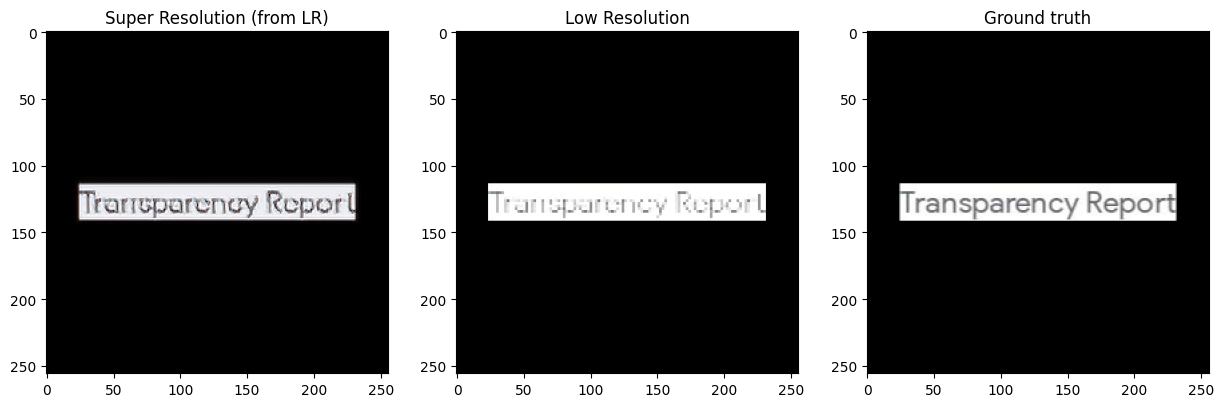

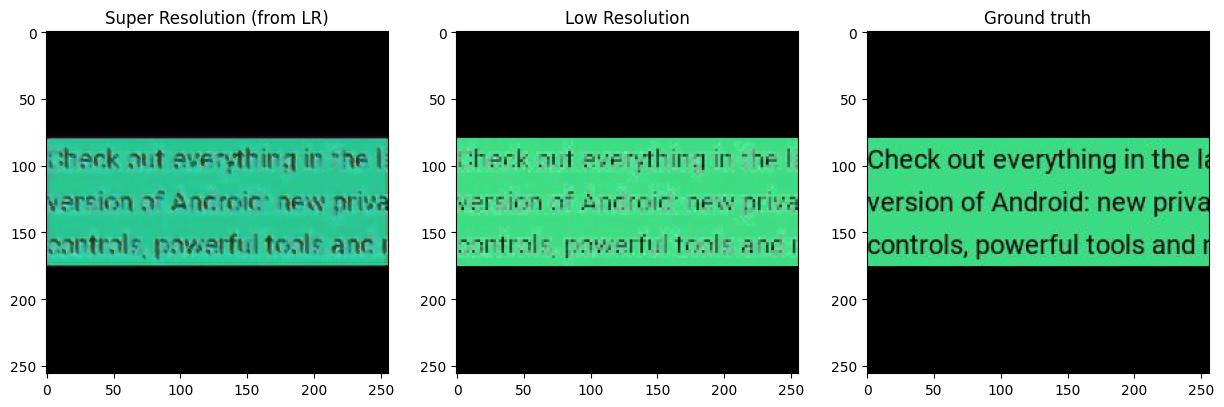

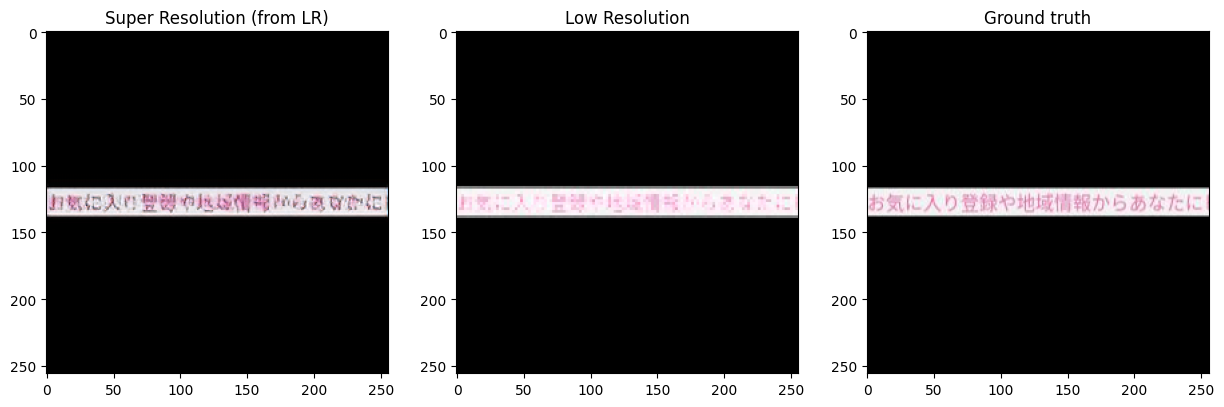

In [76]:
show_pictures(runet_exp, 8, x_chunk_train, y_chunk_train) 
show_pictures(runet_exp, 18, x_chunk_train, y_chunk_train) 
show_pictures(runet_exp, 20+18, x_chunk_train, y_chunk_train)

In [ ]:
x_chunk_test = []
y_chunk_test = []
ids_test_chunk_test = test_list[0:chunk_test_size]
for i,ids in enumerate(ids_test_chunk_test):
    ids_128 = '128'.join(ids.split('64'))
    img_x = read_image(ids)
    img_x = image_preprocess(img_x, training_mode=False)
    img_y = read_image(ids_128)

    x_chunk_test.append(np.array(img_x,np.float32)/255.)
    y_chunk_test.append(np.array(img_y,np.float32)/255.)

x_chunk_test = np.array(x_chunk_test)
y_chunk_test = np.array(y_chunk_test)

In [ ]:
x_chunk_test.shape

(20, 256, 256, 3)

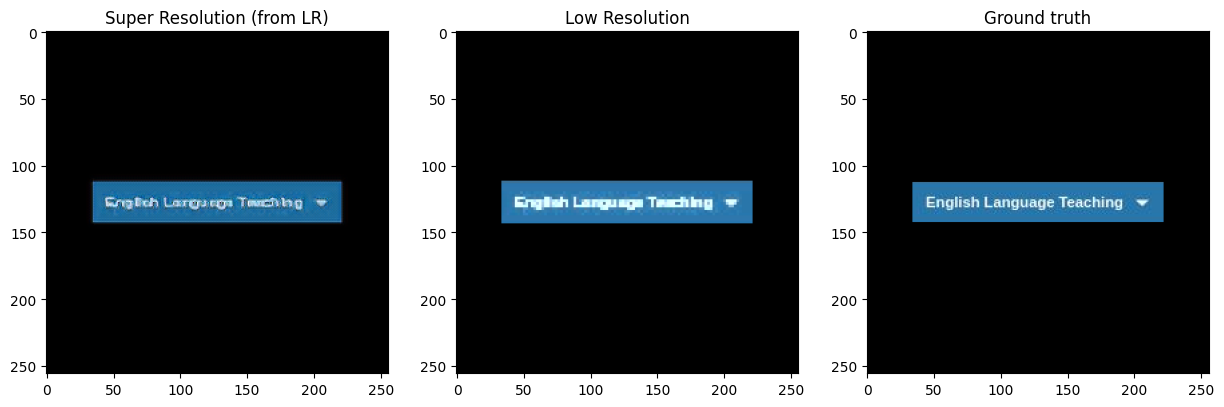

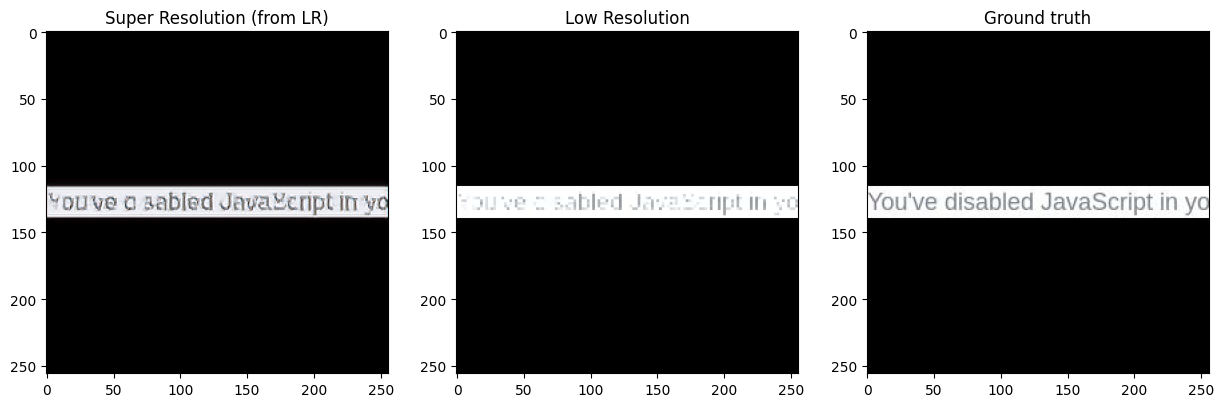

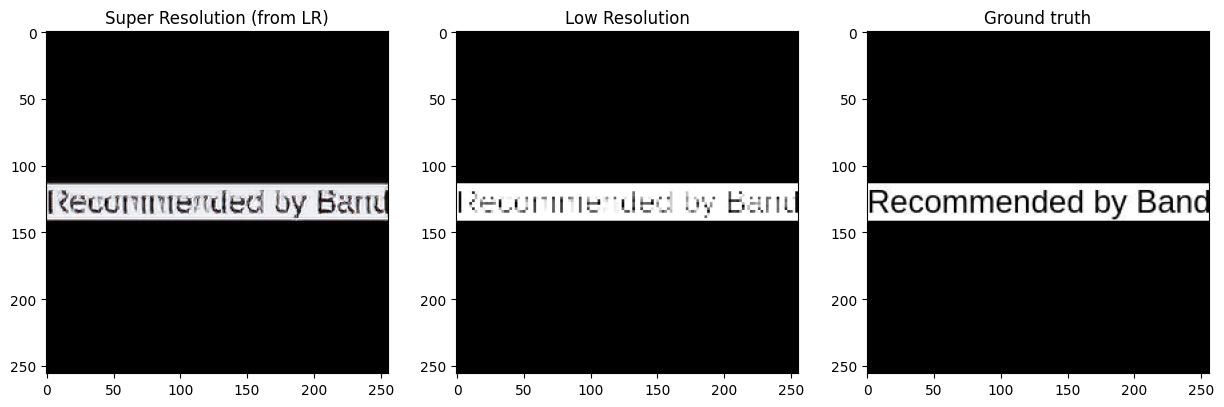

In [ ]:
show_pictures(model, 6, x_chunk_test, y_chunk_test)
show_pictures(model, 7, x_chunk_test, y_chunk_test)
show_pictures(model, 19, x_chunk_test, y_chunk_test)